# Contextual Multi-Arm Bandit
---

## Load Liblareis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression

## Generate Sample Data

In [2]:
def generate_sample_data(sample_num=10000):
    weight = np.array([
        [0.05, 0.05, -0.05],
        [-0.05, 0.05, 0.05],
        [0.05, -0.05, 0.05],
    ])

    arm_num = weight.shape[0]
    feature_wight = weight

    feature_vector = np.random.rand(sample_num, feature_wight.shape[0])
    theta = np.dot(feature_vector, feature_wight)
    is_cv = (theta > np.random.rand(sample_num, arm_num)).astype(np.int8)

    return feature_vector, is_cv, weight

## Define Model

In [3]:
import numpy as np
from joblib import Parallel, delayed

from sklearn.linear_model import LogisticRegression


class ZeroPredictor():

    def predict_proba(self, X):
        return np.c_[np.ones((X.shape[0], 1)),  np.zeros((X.shape[0], 1))]


class OnePredictor():

    def predict_proba(self, X):
        return np.c_[np.zeros((X.shape[0], 1)), np.ones((X.shape[0], 1))]


class ContextualBandit():

    def __init__(self, base_model, n_arm,  n_estimator=100):
        self.n_arm = n_arm
        self.base_model = base_model
        self.n_estimator = n_estimator
        self.estimators = np.array([[base_model for _ in range(n_estimator)] for _ in range(n_arm)])
        self.smpl_count_each_arm = np.zeros(n_arm, dtype=np.int64)

    def fit(self, X, chosen_arm, y):
        for arm_id in range(self.n_arm):
            matched_X = X[(chosen_arm == arm_id)]
            matched_y = y[(chosen_arm == arm_id)]
            
            self.estimators[arm_id] = Parallel(n_jobs=-1)(
                [delayed(self._bagging)(self.base_model, matched_X, matched_y) for estimator in range(self.n_estimator)]
            )
            
            self.smpl_count_each_arm[arm_id] +=  matched_X.shape[0]

    def _bagging(self, model, X, y):
        _X, _y = self._bootstrapped_sampling(X, y)
        if _y.sum() == 0:
            return ZeroPredictor()
        elif _y.sum() == _y.shape[0]:
            return OnePredictor()
        else:
            return model.fit(_X, _y)

    def _bootstrapped_sampling(self, X, y, sample_rate=0.8):
        data_size = X.shape[0]
        bootstrapped_idx = np.random.randint(0, data_size, int(data_size*sample_rate))
        return X[bootstrapped_idx], y[bootstrapped_idx]

    def _thompson_sampling(self, smpl):
        smpl_avg, smpl_std = smpl.mean(), smpl.std()
        return np.random.normal(smpl_avg, smpl_std)
    
    def _predict_proba_with_thompson_sampling(self, arm_id, X):
        
        def _single_predict_proba(model, X):
            return model.predict_proba(X)[:, 1]
            
        proba_result = Parallel(n_jobs=-1)([delayed(_single_predict_proba)(estimator, X) for estimator in  self.estimators[arm_id]])
        
        proba_mean = np.mean(proba_result, axis=0)
        proba_std = np.std(proba_result, axis=0)
        
        return [np.random.normal(p, s) for p, s in zip(proba_mean, proba_std)]

    def predict(self, X):
        proba_each_users = np.zeros((self.n_arm, X.shape[0]))

        def predict_proba(estimators, X, arm_id):
            proba = np.array([e.predict_proba(X)[:, 1] for e in estimators]).T
            proba = [self._thompson_sampling(p) for p in proba]
            return np.array(proba)
        
        for arm_id in range(self.n_arm):
            proba_each_users[arm_id, :] = self._predict_proba_with_thompson_sampling(arm_id, X)
        
        return np.argmax(proba_each_users, axis=0)


## Train Model

In [37]:
# %%debug

f_vector, rewords, weight = generate_sample_data(sample_num=100000)

n_arm = rewords.shape[1]
base_model = LogisticRegression(solver='lbfgs')
bandit_model = ContextualBandit(base_model, n_arm, n_estimator=10)

batch_size = 100
lr_step = 500

random_rewords = []
predict_rewords = []

pred_arm_history = np.array([]).astype(int)
rand_arm_history = np.array([]).astype(int)

for i in tqdm(range(0, f_vector.shape[0], batch_size)):
    start = i
    end = i + batch_size
    # バッチデータの切り取り
    X_batch = f_vector[start:end, :]
    y_batch = rewords[start:end, :]
    
    # アームの選択
    random_chosen_arms = np.random.randint(n_arm, size=batch_size)
    if i == 0:
        # 初期処理
        chosen_arms = np.random.randint(n_arm, size=batch_size)
        pred_arm_rewords = rewords[np.arange(end), chosen_arms]
        bandit_model.fit(f_vector[:end], chosen_arms, pred_arm_rewords)
    else:
        chosen_arms = bandit_model.predict(X_batch)
    
    rand_arm_history = np.append(rand_arm_history, random_chosen_arms)
    pred_arm_history = np.append(pred_arm_history, chosen_arms)
    # モデルの更新
    if i % lr_step == batch_size:
        pred_arm_rewords = rewords[np.arange(end), pred_arm_history]
        bandit_model.fit(f_vector[:end], pred_arm_history, pred_arm_rewords)
        
    # 報酬を集計
    random_rewords.append(rewords[:end][np.arange(end), rand_arm_history].mean())
    predict_rewords.append(rewords[:end][np.arange(end), pred_arm_history].mean())
    

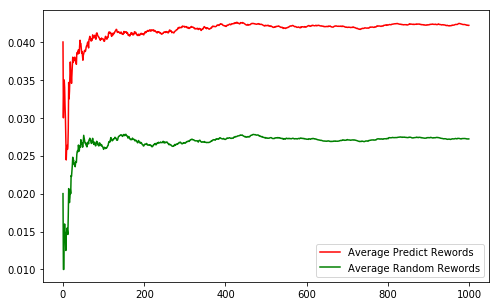

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(predict_rewords, color='r', label='Average Predict Rewords')
plt.plot(random_rewords, color='g', label='Average Random Rewords')
plt.legend()